In [1]:
import numpy as np
import os
import pickle
import time

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
def load_jets(root_dir, filename):
    """Load truth binary trees"""
    #root_dir = "../data/"
    filename = os.path.join(root_dir, filename)
    with open(filename + ".pkl", "rb") as fd:
        Truth= pickle.load(fd, encoding='latin-1')
    return Truth

In [6]:
lambda_truth = 2.4
pt_cut_truth = 30.0

n_lambda = 150
N_jets = 10000

#lambda_min = 1.6
#lambda_max = 2.75

lambda_min = 1.9
lambda_max = 3.05

lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)

Njets = 100000

In [7]:
truth_bin = None
        
for ix, x in enumerate(lambda_vals >= lambda_truth):
    if x.item() is True:
        truth_bin = ix-1
        break

In [4]:
gt_trees = load_jets("data", "ginkgo_{}_jets_no_cuts_lambda_{}_pt_min_{}_jetp_400_with_perm".format(Njets,
                                                                                                    int(lambda_truth*10),
                                                                                                    int(pt_cut_truth)))  # My test file

## Load trellis grid results

In [5]:
def get_likelihood_surface_array(lambda_min, lambda_max, n_lambda,
                                 Njets=10000,
                                 pt_cut=30.0,
                                 likelihood="marginal",
                                 datadir="/scratch/mdd424/data/trellis"):
    
    if likelihood.lower() == "marginal":
        key = "Z"
    elif likelihood.lower() == "map":
        key = "trellis_MLE"
    else:
        return None
    
    lambda_vals = np.linspace(lambda_min, lambda_max, n_lambda)
        
    likelihood_surface = np.zeros((Njets, n_lambda))
    
    for i in range(n_lambda):
        model_params = {"delta_min": pt_cut, "lam": lambda_vals[i]}

        in_filename = os.path.join(datadir, "trellis_{}_jets_1D_lambda_{:n}_ptcut_{:n}_{}_with_perm.pkl".format(
            Njets,
            int(lambda_vals[i])*1000,
            int(pt_cut),
            i))
        with open(in_filename, "rb") as fd:
            results = pickle.load(fd, encoding='latin-1')

        ## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET
        #myresults = np.array(results[key])
        #arr = np.arange(len(myresults))
        #good_indices = ((arr != 4835) & (arr != 9024))
        #myresults = myresults[good_indices]

        for k in range(Njets):
            likelihood_surface[k,i] = results[key][k]
                
    return likelihood_surface

### Load all of the likelihood surfaces

In [8]:
Njets = 100000

likelihood_surface_array = get_likelihood_surface_array(lambda_min, lambda_max, n_lambda,
                                                        Njets=Njets,
                                                        pt_cut=pt_cut_truth,
                                                        likelihood="marginal")
## REMOVE THE TWO BAD JETS FROM THE 10k JET DATASET
arr = np.arange(likelihood_surface_array.shape[0])
#good_indices = arr[((arr != 4835) & (arr != 9024))]
#likelihood_surface_array = likelihood_surface_array[good_indices]

if lambda_truth == 2.4 and pt_cut_truth == 30.0 and Njets == 10000:
    arr = np.arange(likelihood_surface_array.shape[0])
    good_indices = arr[arr != 2942]
    likelihood_surface_array = likelihood_surface_array[good_indices]
    gt_trees = gt_trees[good_indices]

### Remove bad jets

In [10]:
bad_indices = []
for ix, entry in enumerate(likelihood_surface_array):
    if np.isnan(entry).sum() == n_lambda:
        bad_indices.append(ix)
bad_indices = np.array(bad_indices)
        
good_indices = np.arange(likelihood_surface_array.shape[0])
for bad_ix in bad_indices:
    good_indices = good_indices[good_indices != bad_ix]

In [11]:
likelihood_surface_array = likelihood_surface_array[good_indices]
gt_trees = (np.array(gt_trees)[good_indices]).tolist()

## Find the Trellis MLE

In [12]:
total_likelihood_surface = np.sum(likelihood_surface_array, axis=0)

In [13]:
mle_coords = np.unravel_index(np.argmax(total_likelihood_surface[~np.isnan(total_likelihood_surface)], axis=None),
                                  total_likelihood_surface.shape)[0]
mle_coords

118

# Look at reweighting the likelihood

### Some possible correction terms

In [14]:
def correction_term(lam, pt_cut, delta0):
    return -np.log(1 - np.exp(- lam)) + np.log(1 - np.exp(-lam * pt_cut / delta0))

def correction_term2(lam, pt_cut, delta0):
    return np.log(1- np.exp(-lam)) - np.log(np.exp(-lam * pt_cut / delta0) - np.exp(-lam))

## Look at importance sampling reweighting

In [15]:
other_bin = None
        
for ix, x in enumerate(lambda_vals >= 2):
    if x.item() is True:
        other_bin = ix-1
        break

#other_bin = mle_coords
print(other_bin, lambda_vals[other_bin], truth_bin)

12 1.9926174496644293 64


In [16]:
trellis_mle_jets = load_jets("/scratch/mdd424/data/ginkgo", "ginkgo_20000_jets_1D_jetp_400_lambda_{:n}_ptcut_{:n}_{}".format(
    int(lambda_vals[other_bin])*1000,
    int(pt_cut_truth),
    other_bin))

In [17]:
truth_num_leaves = np.array([len(x["leaves"]) for x in gt_trees])
truth_num_leaves_sigma = np.sqrt(np.histogram(truth_num_leaves, bins=np.arange(1,16)-0.5)[0]) / truth_num_leaves.size

trellis_num_leaves = np.array([len(x["leaves"]) for x in trellis_mle_jets])
trellis_num_leaves_sigma = np.sqrt(np.histogram(trellis_num_leaves, bins=np.arange(1,16)-0.5)[0]) / trellis_num_leaves.size

In [18]:
Njets = len(gt_trees)
#Njets = 1000
print(Njets)

p_n = np.zeros(20)
v_n = np.zeros(20)
for ix in range(Njets):
    w = 1*np.exp(likelihood_surface_array[ix, other_bin] - likelihood_surface_array[ix, truth_bin])
    p_n[truth_num_leaves[ix]-1] += w
    v_n[truth_num_leaves[ix]-1] += w**2
    
p_n /= Njets
v_n /= Njets**2
sigma_n = np.sqrt(v_n)
w_tot = p_n.sum()

99976


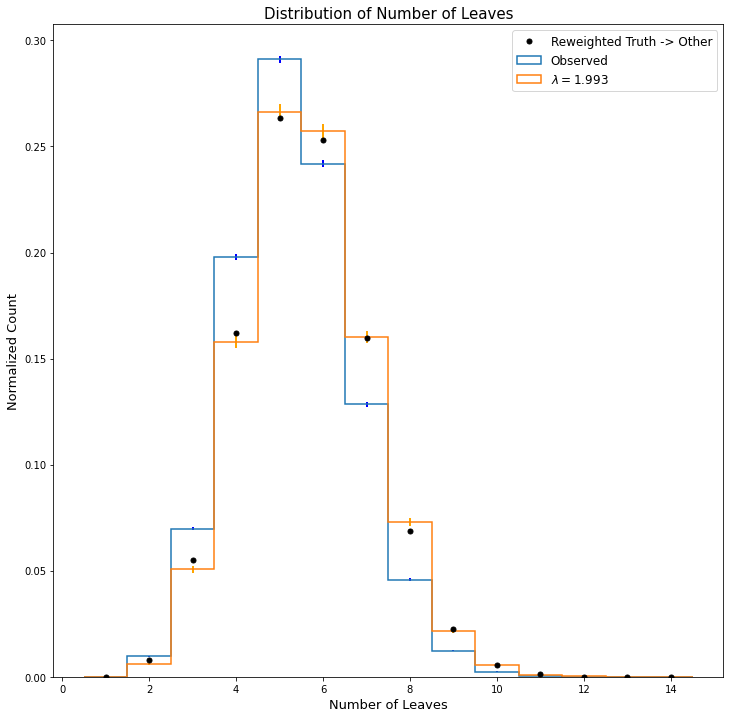

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(12,12)

truth_hist = ax.hist(truth_num_leaves, bins=np.arange(1,16)-0.5, histtype="step", linewidth=1.5, density=True, label="Observed")
trellis_hist = ax.hist(trellis_num_leaves, bins=np.arange(1,16)-0.5, histtype="step", linewidth=1.5,  density=True, label="$\lambda = {:.3f}$".format(lambda_vals[other_bin]))
ax.plot(np.arange(1,15), p_n[:14] / w_tot, ".", markersize=10, color="black", label="Reweighted Truth -> Other")
for i in range(14):
    ax.vlines(i+1,
              ymin=(p_n[i] - sigma_n[i])/w_tot,
              ymax=(p_n[i] + sigma_n[i])/w_tot,
              colors="black", linestyle="solid", linewidth=2)
    ax.vlines(i+1,
              ymin=truth_hist[0][i] - truth_num_leaves_sigma[i],
              ymax=truth_hist[0][i] + truth_num_leaves_sigma[i],
              colors="blue", linestyle="solid", linewidth=2)
    ax.vlines(i+1,
              ymin=trellis_hist[0][i] - trellis_num_leaves_sigma[i],
              ymax=trellis_hist[0][i] + trellis_num_leaves_sigma[i],
              colors="orange", linestyle="solid", linewidth=2)

ax.set_xlabel("Number of Leaves", size=13)
ax.set_ylabel("Normalized Count", size=13)
ax.set_title("Distribution of Number of Leaves", size=15)
ax.legend(fontsize="large")

## Look at how correction terms affect results

In [20]:
corrected_likelihood_surface_array1 = likelihood_surface_array + correction_term(lambda_vals, pt_cut_truth, 900)
corrected_likelihood_surface_array2 = likelihood_surface_array + correction_term2(lambda_vals, pt_cut_truth, 900)

In [21]:
total_corrected_likelihood_surface1 = np.sum(corrected_likelihood_surface_array1, axis=0)
total_corrected_likelihood_surface2 = np.sum(corrected_likelihood_surface_array2, axis=0)

In [22]:
corrected_mle_coords1 = np.unravel_index(np.argmax(total_corrected_likelihood_surface1, axis=None), total_corrected_likelihood_surface1.shape)[0]
corrected_mle_coords2 = np.unravel_index(np.argmax(total_corrected_likelihood_surface2, axis=None), total_corrected_likelihood_surface2.shape)[0]
corrected_mle_coords1, corrected_mle_coords2

(149, 131)

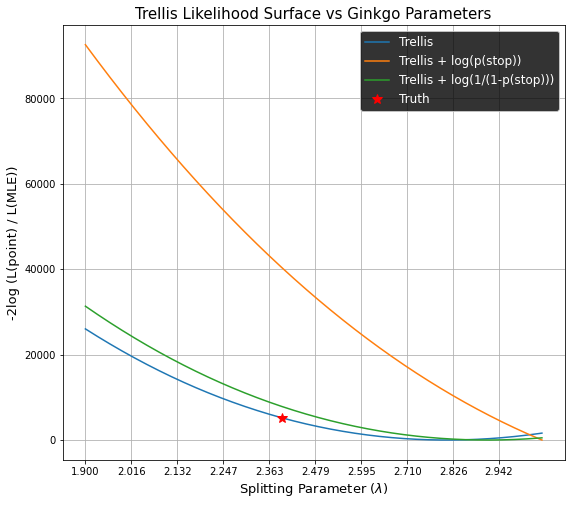

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(total_likelihood_surface-total_likelihood_surface.max())
Zc1 = -2*(total_corrected_likelihood_surface1-total_corrected_likelihood_surface1.max())
Zc2 = -2*(total_corrected_likelihood_surface2-total_corrected_likelihood_surface2.max())

ax.plot(lambda_vals, Z, label="Trellis")
ax.plot(lambda_vals, Zc1, label="Trellis + log(p(stop))")
ax.plot(lambda_vals, Zc2, label="Trellis + log(1/(1-p(stop)))")

ax.plot(lambda_vals[truth_bin], Z[truth_bin], '*', label="Truth", markersize=10, color="red")

ax.legend(labelcolor="white", facecolor="black", fontsize="large")
ax.grid()

ax.set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_ylabel("-2log (L(point) / L(MLE))", size=13)
#ax.set_ylabel("logLikelihood", size=13)
ax.set_xticks(lambda_vals[::15]);

In [24]:
def get_avg_reweighting(loglikelihood_surface_array, lambda_bin, truth_bin=truth_bin):
    Njets = loglikelihood_surface_array.shape[0]

    p_n = 0
    for ix in range(Njets):
        p_n += 1*np.exp(loglikelihood_surface_array[ix, lambda_bin] - loglikelihood_surface_array[ix, truth_bin])

    p_n /= Njets
    return p_n

In [25]:
avg_reweight_vals = np.array([get_avg_reweighting(likelihood_surface_array, lam_bin) for lam_bin in range(len(lambda_vals))])
avg_reweight_vals2 = np.array([get_avg_reweighting(likelihood_surface_array, lam_bin, truth_bin=10) for lam_bin in range(len(lambda_vals))])
avg_reweight_vals3 = np.array([get_avg_reweighting(likelihood_surface_array, lam_bin, truth_bin=100) for lam_bin in range(len(lambda_vals))])

In [26]:
correction_terms = np.exp(correction_term(lambda_vals, pt_cut_truth, 900) - correction_term(lambda_truth, pt_cut_truth, 900))

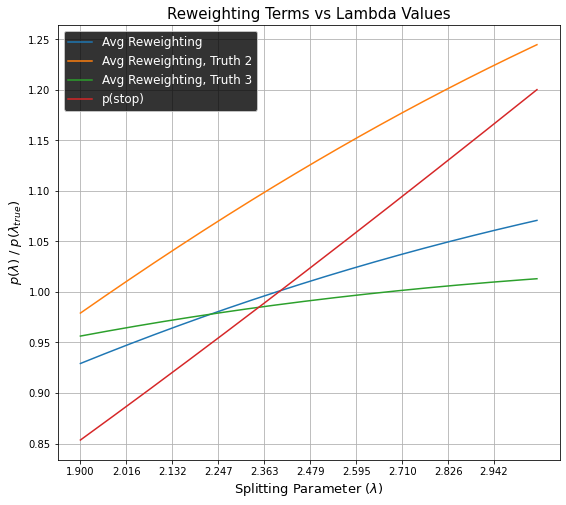

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

ax.plot(lambda_vals, avg_reweight_vals, label="Avg Reweighting")
ax.plot(lambda_vals, avg_reweight_vals2, label="Avg Reweighting, Truth 2")
ax.plot(lambda_vals, avg_reweight_vals3, label="Avg Reweighting, Truth 3")

ax.plot(lambda_vals, correction_terms, label="p(stop)")


ax.legend(labelcolor="white", facecolor="black", fontsize="large")
ax.grid()

ax.set_title("Reweighting Terms vs Lambda Values", size=15)
ax.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_ylabel("$p(\lambda)\ /\ p(\lambda_{true})$", size=13)
ax.set_xticks(lambda_vals[::15]);

In [28]:
total_reweighted_likelihood_surface = np.sum(likelihood_surface_array - np.log(avg_reweight_vals), axis=0)

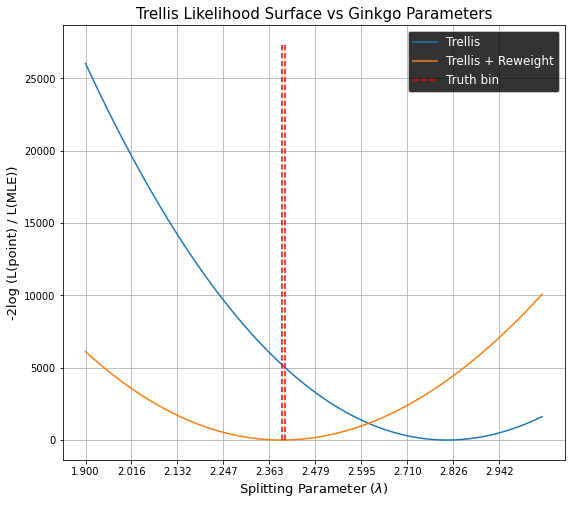

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(total_likelihood_surface-total_likelihood_surface.max())
Z2 = -2*(total_reweighted_likelihood_surface-total_reweighted_likelihood_surface.max())


ax.plot(lambda_vals, Z, label="Trellis")
ax.plot(lambda_vals, Z2, label="Trellis + Reweight")

y_min, y_max = ax.get_ylim()
    
ax.vlines(lambda_vals[truth_bin], ymin=0, ymax=y_max, colors="red", linestyle="dashed",
           linewidth=1.5, label="Truth bin", zorder=1e4)
ax.vlines(lambda_vals[truth_bin+1], ymin=0, ymax=y_max, colors="red", linestyle="dashed", linewidth=1.5, zorder=1e4)


ax.legend(labelcolor="white", facecolor="black", fontsize="large")
ax.grid()

ax.set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Splitting Parameter ($\lambda$)", size=13)
ax.set_ylabel("-2log (L(point) / L(MLE))", size=13)
#ax.set_ylabel("logLikelihood", size=13)
ax.set_xticks(lambda_vals[::15]);

In [32]:
with open("./data/test_10jets_dataset_lambda_24_pt_cut_30.pkl", 'wb') as f:
    pickle.dump(gt_trees[:10], f)

In [31]:
[len(x["leaves"]) for x in gt_trees[:10]]

[8, 6, 6, 4, 7, 5, 5, 7, 6, 5]